# Classification with Scikit-Learn #

By John Semerdjian, assisted by Marti Hearst

October 2015

This is a tutorial on how to use Sciki-Learn in combination with Pandas to train and test a text classification algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

### Reading a csv file

Let's import data straight into a `DataFrame` from most file types, e.g. `.csv` or `.json`.

Download the consumer complaints dataset as a `.csv` file here: https://data.consumerfinance.gov/dataset/Consumer-Complaints/s6ew-h6mp

Description from [Consumer Financial Protection Bureau](http://www.consumerfinance.gov/complaintdatabase/):

> Each week we send thousands of consumers' complaints about financial products and services to companies for response. Complaints are listed in the database after the company responds or after they’ve had the complaint for 15 calendar days, whichever comes first.

> We publish the consumer’s description of what happened if the consumer opts to share it and after taking steps to remove personal information. See our Scrubbing Standard for more details

> We don’t verify all the facts alleged in these complaints, but we take steps to confirm a commercial relationship. We may remove complaints if they don’t meet all of the publication criteria. Data is refreshed nightly.

In [3]:
df = pd.read_csv("Consumer_Complaints.csv", low_memory=False)

### First look at your data

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/31/2015,Debt collection,Credit card,Taking/threatening an illegal action,Threatened to sue on too old debt,NaN,NaN,Transworld Systems Inc.,NY,104XX,Web,08/31/2015,In progress,Yes,NaN,1544816
1,08/31/2015,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"FNIS (Fidelity National Information Services, ...",CA,92054,Web,08/31/2015,In progress,Yes,NaN,1545382
2,08/31/2015,Debt collection,"Other (phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,NaN,NaN,"Hunter Warfield, Inc.",TX,750XX,Web,08/31/2015,In progress,Yes,NaN,1544066
3,08/31/2015,Debt collection,Medical,Communication tactics,Threatened to take legal action,NaN,NaN,Transworld Systems Inc.,FL,33596,Web,08/31/2015,In progress,Yes,NaN,1545215
4,08/31/2015,Debt collection,"Other (phone, health club, etc.)",Improper contact or sharing of info,Talked to a third party about my debt,NaN,Company believes complaint represents an oppor...,"Hunter Warfield, Inc.",TN,372XX,Web,08/31/2015,Closed with explanation,Yes,NaN,1545291


### The data is really wide! Let's extract a few columns to review

We can pass a list of column names to our filter our DataFrame

In [5]:
cols = ["Product", "Sub-product", "Issue", "Sub-issue", 
        "Consumer complaint narrative", "Company public response", 
        "Company", "Company response to consumer"]

Put the list of column names in brackets after the name of the DataFrame to subset. 

In [6]:
df[cols].head()

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,Company response to consumer
0,Debt collection,Credit card,Taking/threatening an illegal action,Threatened to sue on too old debt,NaN,NaN,Transworld Systems Inc.,In progress
1,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"FNIS (Fidelity National Information Services, ...",In progress
2,Debt collection,"Other (phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,NaN,NaN,"Hunter Warfield, Inc.",In progress
3,Debt collection,Medical,Communication tactics,Threatened to take legal action,NaN,NaN,Transworld Systems Inc.,In progress
4,Debt collection,"Other (phone, health club, etc.)",Improper contact or sharing of info,Talked to a third party about my debt,NaN,Company believes complaint represents an oppor...,"Hunter Warfield, Inc.",Closed with explanation


### Return all rows that do not have `NaN` in the `Consumer complaint narrative` column

The `df["Consumer complaint narrative"].notnull()` argument returns a boolean of values, `True` if the data are not null (`NaN`) and `False` for the rest. We place the array of boolean values within the DataFrame `df` to subset it further.  Farther down we will see how the `reset_index()` function gives us a clean index so we don't have to use the same indices as the larger DataFrame for subsetting.

In [7]:
filtered_data = df["Consumer complaint narrative"].notnull()
filtered_data[:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: Consumer complaint narrative, dtype: bool

In [10]:
df_narrative = df[filtered_data]

Notice where the index starts on the left-most column -- it is no longer in descending order from 0 to the length of the number of rows.

In [11]:
df_narrative[cols].head()

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,Company response to consumer
89,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,My report seems to have several new hard inqui...,Company chooses not to provide a public response,TransUnion,Closed with non-monetary relief
95,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting my free annual report,Online identity verification questions ask non...,Company chooses not to provide a public response,TransUnion,Closed with explanation
97,Credit reporting,NaN,Incorrect information on credit report,Account status,I had a car loan with XXXX XXXX that was paid ...,Company chooses not to provide a public response,TransUnion,Closed with explanation
101,Debt collection,Medical,Disclosure verification of debt,Not disclosed as an attempt to collect,I would like delete the debt in my credit repo...,Company believes it acted appropriately as aut...,"Gold Key Credit, Inc.",Closed with explanation
107,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,I mailed a letter to Medical Business Bureau i...,Company believes it acted appropriately as aut...,Medical Business Bureau,Closed with explanation


### Ploting with Pandas

We can plot the distribution of categories in the `Products` column by chaining the `.value_counts()` and `.plot()` methods after selecting the `Products` column

We can then count for each unique value in that column the number of observations within in the DataFrame, which we sort ascending.

In [14]:
sorted_product_counts = df_narrative.Product.value_counts(ascending=True)
sorted_product_counts

Other financial service      34
Prepaid card                129
Money transfers             218
Payday loan                 250
Student loan                728
Consumer loan              1042
Bank account or service    1733
Credit card                2246
Credit reporting           4181
Mortgage                   4713
Debt collection            5932
dtype: int64

Next, we can plot a horizatontal (`barh`) bar graph to view the results, fix the fiture size to 8x6, and give it a title.

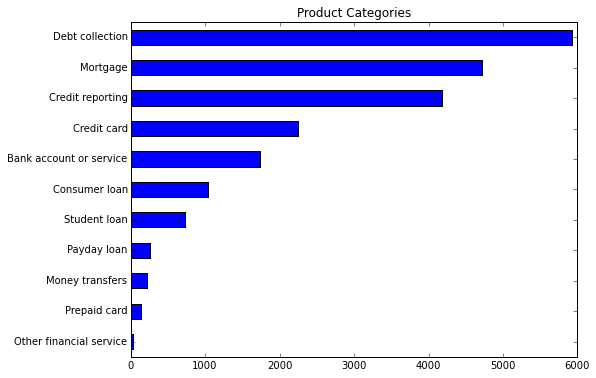

In [15]:
sorted_product_counts.plot(kind='barh', figsize=(8,6), title="Product Categories");

### Create training, development, and test sets

First, let's shuffle the rows in our `DataFrame`. There are many ways of splitting our data into training, development, and test sets. We'll use the `numpy` function `random.permutation` to generate a randomized array of row indices. 

(Alternatively, we can use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function from `sklearn.cross_validation` to easily create training and "test" sets.)

In [16]:
df_narrative.index[:10]

Int64Index([89, 95, 97, 101, 107, 115, 121, 123, 130, 139], dtype='int64')

In [17]:
random_index = np.random.permutation(df_narrative.index)
random_index[:10]

array([41422, 23676, 38756, 60330, 69697, 44151, 53263, 26173, 23458, 38067])

After we apply this randomized index, we'll need to reset the index of our new `DataFrame`. This allows us to us the normal indexing approaches.



In [18]:
df_narrative.ix[random_index, ['Product', 'Consumer complaint narrative']][:5]

,Product,Consumer complaint narrative
41422,Bank account or service,I had my 2015 tax return sent to net spend on ...
23676,Credit card,I had an American Express credit card. I close...
38756,Debt collection,In XX/XX/XXXX I received a notice that I owed ...
60330,Mortgage,My spouse lost his job and we fell behind on o...
69697,Mortgage,"My name is XXXX XXXX, XXXX XXXX XXXX XXXX, XXX..."


The `drop=True` option in `reset_index()` resets our rows without adding a new column indicated the old index while `inplace=True` performs the operation in place instead of returning a copy of the `DataFrame`

In [19]:
df_narrative_shuffled = df_narrative.ix[random_index, ['Product', 'Consumer complaint narrative']]
df_narrative_shuffled.reset_index(drop=True, inplace=True)
df_narrative_shuffled[:5]

,Product,Consumer complaint narrative
0,Bank account or service,I had my 2015 tax return sent to net spend on ...
1,Credit card,I had an American Express credit card. I close...
2,Debt collection,In XX/XX/XXXX I received a notice that I owed ...
3,Mortgage,My spouse lost his job and we fell behind on o...
4,Mortgage,"My name is XXXX XXXX, XXXX XXXX XXXX XXXX, XXX..."


### Create 60/20/20 split for training/dev/test sets

The `.shape` function returns a tuple of the number of rows and columns in a DataFrame

In [20]:
rows, columns = df_narrative_shuffled.shape
print("Rows:", rows)
print("Columns:", columns)

Rows: 21206
Columns: 2


In [21]:
train_size = round(rows*.6)
dev_size   = round(rows*.2)

First 60% of rows are the training set

In [22]:
df_train = df_narrative_shuffled.loc[:train_size]
df_train.shape

(12725, 2)

In [23]:
df_train.head()

,Product,Consumer complaint narrative
0,Bank account or service,I had my 2015 tax return sent to net spend on ...
1,Credit card,I had an American Express credit card. I close...
2,Debt collection,In XX/XX/XXXX I received a notice that I owed ...
3,Mortgage,My spouse lost his job and we fell behind on o...
4,Mortgage,"My name is XXXX XXXX, XXXX XXXX XXXX XXXX, XXX..."


Followed by the next 20% of rows for the development set

In [24]:
df_dev = df_narrative_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)
df_dev.shape

(4242, 2)

And the last 20% are the test set

In [25]:
df_test = df_narrative_shuffled.loc[dev_size+train_size:].reset_index(drop=True)
df_test.shape

(4241, 2)

# Scikit-Learn

After we've wrangled/cleaned/separated our data with `Pandas`, we can start building machine learning algorithms using `Scikit-Learn`, which gives us a rich, unified API to quickly create classification models.

### Building features from scratch

Let's say you have an intuition for the terms you think would be helpful for classification consumer complaints. We can quickly create a column vector for each feature you think of then use a simple classification algorithm for prediction.

For now let's just build features to classify credit card-related compliants.

I thought of the following features:

* character: "$"
* word: "payment"
* bigram: "credit card"

There are two feature processing functions below.  One handles features consisting of one word, and the other handles features consisting of two words.  They count how often the passed in term occurs in the document.  In the bigram case, a FreqDist is needed to keep track.

In [26]:
def unigram_feature(x, unigram):
    word_list = x.lower().split(" ")
    return word_list.count(unigram)

def bigram_feature(x, bigram):
    bigram_tuple = tuple(bigram.split())
    word_list = x.lower().split(" ")
    bi = nltk.FreqDist(nltk.bigrams(word_list))
    return bi[bigram_tuple]

Train the dollar sign feature.  It doesn't occur in the first 10 documents.

In [27]:
train_dollarsign_feature = df_train['Consumer complaint narrative'].apply(lambda x: unigram_feature(x, ('$')))
train_dollarsign_feature[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Consumer complaint narrative, dtype: int64

Train the 'payment' feature.  It occurs twice in document 1 and one time in document 8.

In [28]:
train_payment_feature = df_train['Consumer complaint narrative'].apply(lambda x: unigram_feature(x, ('payment')))
train_payment_feature[:10]

0    0
1    0
2    0
3    1
4    3
5    0
6    1
7    0
8    0
9    0
Name: Consumer complaint narrative, dtype: int64

In [29]:
train_creditcard_feature = df_train['Consumer complaint narrative'].apply(lambda x: bigram_feature(x, ('credit card')))
train_creditcard_feature[:10]

0    0
1    4
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Consumer complaint narrative, dtype: int64

Bring your feature vectors together into a `DataFrame`

In [30]:
df_train_features = pd.DataFrame({'dollar': train_dollarsign_feature, 
                                  'payment': train_payment_feature, 
                                  'creditcard': train_creditcard_feature})

In [31]:
df_train_features.head()

,creditcard,dollar,payment
0,0,0,0
1,4,0,0
2,0,0,0
3,0,0,1
4,0,0,3


Create the feature vectors for the development set too

In [32]:
dev_dollarsign_feature = df_dev['Consumer complaint narrative'].apply(lambda x: unigram_feature(x, ('$')))
dev_payment_feature = df_dev['Consumer complaint narrative'].apply(lambda x: unigram_feature(x, ('payment')))
dev_creditcard_feature = df_dev['Consumer complaint narrative'].apply(lambda x: bigram_feature(x, ('credit card')))

In [33]:
df_dev_features = pd.DataFrame({'dollar': dev_dollarsign_feature, 
                                'payment': dev_payment_feature, 
                                'creditcard': dev_creditcard_feature})

In [34]:
df_dev_features.head()

,creditcard,dollar,payment
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### Building a model using your features

We'll build a single Naive Bayes to predict the product category based on the consumer complain features we just created.  The 'fit' function does the training.  We pass in the features and the correct classes that we want as output (the Product column) as the arguments.

In [35]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_model = nb.fit(df_train_features, df_train.Product)

The predict function does the classification.

In [36]:
nb_predictions = nb_model.predict(df_dev_features)
nb_predictions[0]

'Debt collection'

We'll use a `Scikit-Learn` function to calculate the accuracy.

In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(df_dev.Product, nb_predictions)

0.32272512965582273

Ouch! That's not a very good overall score. Let's look at individual class accuracy.

### Classification report

Another way of evaluating the performance of your models is to use `Scikit-Learn`'s `classification_report` function.

* **Precision**:
$$\frac{TP} {TP+FP}$$

* **Recall, Sensitivity, TP Rate**:
$$\frac{TP} {TP+FN}$$

* **$F_1$ Measure**:
$$F _1 = 2 \frac{PR} {P + R}$$

The class labels are usually returned sorted in alphabetical/numerical order.

In [38]:
class_labels = np.sort(df_train.Product.unique())

Run the full report

In [39]:
from sklearn.metrics import classification_report

print(classification_report(df_dev.Product, nb_predictions, target_names=class_labels))

                         precision    recall  f1-score   support

Bank account or service       0.11      0.01      0.02       338
          Consumer loan       0.00      0.00      0.00       218
            Credit card       0.61      0.15      0.24       465
       Credit reporting       0.13      0.04      0.07       844
        Debt collection       0.31      0.83      0.45      1134
        Money transfers       0.00      0.00      0.00        34
               Mortgage       0.41      0.33      0.37       962
Other financial service       0.00      0.00      0.00         8
            Payday loan       0.00      0.00      0.00        57
           Prepaid card       0.00      0.00      0.00        23
           Student loan       0.00      0.00      0.00       159

            avg / total       0.28      0.32      0.24      4242



/Users/nicolassoldi/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Creating feature using overall word counts

Another strategy of creating features is to use *all* the words in our collection. [`CountVectorizer()`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) accepts an array of text and converts the text through tokenization and counting unique terms, thereby generating our so-called "bag of words".

In other words, for each row in our `DataFrame` we get a long vector/array of the counts of each word.  You can modify the tokenizer, remove stop words, generate n-gram features, and perform other types of text processing. 

Here are some options to explore:

`token_pattern : string`

> Regular expression denoting what constitutes a “token”, only used if tokenize == ‘word’. The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).

`min_df : float in range [0.0, 1.0] or int, default=1`

> When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

`max_features : int or None, default=None`

> If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. This parameter is ignored if vocabulary is not None.

`stop_words : string {‘english’}, list, or None (default)`

> If ‘english’, a built-in stop word list for English is used. If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.


`ngram_range : tuple (min_n, max_n)`

> The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.


If you're interested in using Tf-Idf instead of counts, check out [`TfidfVectorizer()`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

The [feature extraction documentation](http://scikit-learn.org/stable/modules/feature_extraction.html) from Scikit-Learn is also very good.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

Let's use n-gram between 1 to 2 values with a simplified token pattern to find ngrams that occur more than 5 times in the collection.

In [41]:
vec = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=5)

We can manually inspect what the tokenizer does by passing in a string

In [42]:
tokenizer = vec.build_tokenizer()

In [43]:
tokenizer("What's the warranty for this $40.00 toaster?")

['What', 's', 'the', 'warranty', 'for', 'this', '40', '00', 'toaster']

For starters, we'll use the default tokenization pattern and all the text across the **training set** to create our feature vectors. The `fit_transform()` performs this activity and returns a sparse array of the word counts.

In [44]:
arr_train_feature_sparse = vec.fit_transform(df_train["Consumer complaint narrative"])
arr_train_feature_sparse

<12725x56098 sparse matrix of type '<class 'numpy.int64'>'
	with 2694676 stored elements in Compressed Sparse Row format>

A sparse matrix is an efficient way of storing data where most values are 0. Just for information's sake, below we convert the sparse array into a normal array to get a better sense of what's going on.

In [45]:
arr_train_feature = arr_train_feature_sparse.toarray()
arr_train_feature

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Instead of getting back a `Pandas DataFrame`, we get back a `numpy array` object.

### Inspecting our features

To see what our features are, we'll use the `get_feature_names()` function on our `vec` object that we fitted and transformed.  Remember that we asked for both unigrams and bigrams when we created the feature vector.

You'll see a lot of nonsensical features there. What are some strategies that you can think of to make the tokenizer produce more informative features?

In [46]:
feature_labels = vec.get_feature_names()
feature_labels[100:110]

['00 mortgage',
 '00 my',
 '00 negative',
 '00 no',
 '00 not',
 '00 now',
 '00 nsf',
 '00 ocwen',
 '00 of',
 '00 off']

Let's try matching one word from the first row in our `DataFrame` to it's respective position in our feature vector.

In [47]:
row0 = df_train.ix[0, 'Consumer complaint narrative']
row0

"I had my 2015 tax return sent to net spend on XXXX XXXX. They let me make couple of with draws. Then they put a block on it. They wanted information that I could n't provide.So I told them to mail it to me.I call several times and talked to many supervisors and all gave me different information.They claim they mail it off.Here are some of the dates XX/XX/XXXX XX/XX/XXXX, XX/XX/XXXX &, XX/XX/XXXX all dates had a20 day waiting period. As of today date XX/XX/XXXX I have n't received it.Now every time I call I 'm holding till the line click off. "

This is how we search for a word in the feature labels.

In [48]:
feature_index = feature_labels.index('credit')
feature_index

13985

We should expect the count of the number of occurrences

In [49]:
arr_train_feature[0, feature_index]

0

In order to build our model, we'll need to perform the same transformation on our dev and test sets as we did on the training set.  To do this, we use the `transform()` function.

Note that we use 'transform()' and not  `fit_transform()` since that would reset the features using the text from the dev or test set. We only want to use the features that are present in the training set.

In [50]:
arr_dev_feature_sparse = vec.transform(df_dev["Consumer complaint narrative"])
arr_dev_feature = arr_dev_feature_sparse.toarray()

### We have way more features than observations!

This is a good time to consider dimensionality reduction.

In [51]:
arr_train_feature.shape

(12725, 56098)

### Most common features

Let's plot the distribution of counts for the massive feature set we created.

In [52]:
feature_sum = arr_train_feature.sum(axis=0)

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()

Top 10 features

In [53]:
df_feature_sum.sort('counts', ascending=False)[:10]

,counts
xxxx,114497
the,93907
i,88350
to,78758
and,63081
a,48082
my,46821
xxxx xxxx,37189
of,36440
that,35954


Plot the top 50 features

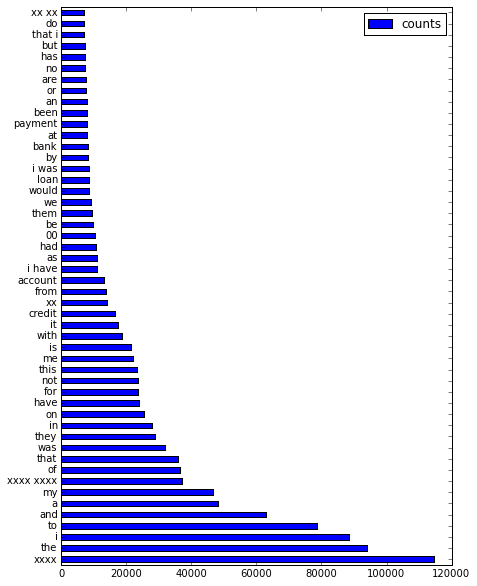

In [54]:
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

### Many of these features are stopwords

How might we fix this?  (Hint: this makes the algorithm work much better on this classification problem.)

### Let's manually reduce our dimensions by using only use the top N features in our training set

Since so many of our features rarely occur, let's (arbitrary) cap our features to the top 1000 most common n-grams using the `max_features` variable within the `CountVectorizer()` function.

In [55]:
vec = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=5, max_features=1000)
arr_train_feature_sparse = vec.fit_transform(df_train["Consumer complaint narrative"])
arr_train_feature = arr_train_feature_sparse.toarray()
arr_train_feature.shape

(12725, 1000)

Remember that if you transform the training set, you also have to transfomr the development set using this new vector vec to get the desired effect.

In [56]:
arr_dev_feature_sparse = vec.transform(df_dev["Consumer complaint narrative"])
arr_dev_feature = arr_dev_feature_sparse.toarray()
arr_dev_feature.shape

(4242, 1000)

# Train two machine learning classification models

### Naive Bayes (generative)

This initializes a [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) model which we then fit in the next row. We pass the training features along with their true labels, `df_train.Product`.

In [57]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_model = nb.fit(arr_train_feature, df_train.Product)

We can easily predict the labels using our new model and the feature vectors from the dev set.

In [58]:
nb_predictions = nb_model.predict(arr_dev_feature)
nb_predictions[0]

'Money transfers'

This function returns the accuracy of our Naive Bayes model.

In [ ]:
accuracy_score(df_dev.Product, nb_predictions)

Instead of looking at the class labels, let's look at the probability of predicting each class.

In [ ]:
nb_predictions_probs = nb_model.predict_proba(arr_dev_feature)
nb_predictions_probs.shape

Plot the predicted probabilities of each class for the first observation in our dev set.

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(nb_predictions_probs[0,:])
plt.xticks(np.arange(11), class_labels, rotation='vertical')
plt.show()

What does the text look like for the first observation in the dev set?

In [ ]:
df_dev.loc[0, 'Consumer complaint narrative']

It's real label?

In [ ]:
df_dev.loc[0, 'Product']

### Logistic Regression (discriminative)

We perform the same steps here as we did above.

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train.Product)

In [63]:
logreg_predictions = logreg_model.predict(arr_dev_feature)

In [64]:
accuracy_score(df_dev.Product, logreg_predictions)

0.76685525695426682

Let's compare the probabilities for the first observation in the dev set between logistic regression and naive bayes.

In [65]:
logreg_predictions_probs = logreg_model.predict_proba(arr_dev_feature)

NameError: name 'nb_predictions_probs' is not defined

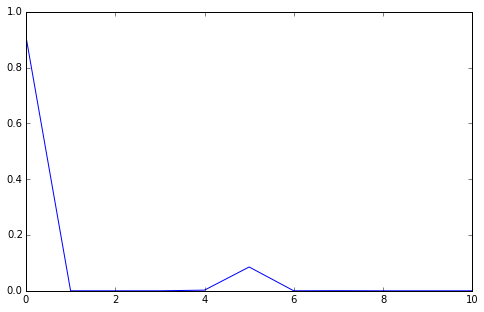

In [66]:
plt.figure(figsize=(8,5))
plt.plot(logreg_predictions_probs[0,:], label='Logistic Regression')
plt.plot(nb_predictions_probs[0,:], label='Naive Bayes')
plt.xticks(np.arange(11), class_labels, rotation='vertical')
plt.legend(frameon=False)
plt.show()

In [ ]:
logreg_predictions[0]

# Create Confusion Matrix

A confusion matrix is handy when inspecting the errors from a multi-class classification problem. Each row and column represents the how well our predicted labels matched their true values. 

`Scikit-Learn` has a function called `confusion_matrix()` which produces array with this data. However, the `Pandas crosstab` function does a better job displaying this information.

Remember, if our model had 100% accuracy, we would expect only the diagonal values to be populated.

In [ ]:
pd.crosstab(df_dev.Product, nb_predictions, 
            rownames=['True'], colnames=['Predicted'], 
            margins=True)

In [ ]:
pd.crosstab(df_dev.Product, logreg_predictions, 
            rownames=['True'], colnames=['Predicted'], 
            margins=True)

We created a function to help you visualize the confusion matrix data below.

In [ ]:
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Plot Confusion Matrix

Confusion Matrix names are sorted by the `confusion_matrix` function in Scikit-Learn

In [ ]:
from sklearn.metrics import confusion_matrix

nb_cm = confusion_matrix(df_dev.Product, nb_predictions)
plot_confusion_matrix(nb_cm, "Naive Bayes Confusion Matrix", class_labels)

In [ ]:
logreg_cm = confusion_matrix(df_dev.Product, logreg_predictions)
plot_confusion_matrix(logreg_cm, "Logistic Regression Confusion Matrix", class_labels)

### Classification report

In [ ]:
print(classification_report(df_dev.Product, nb_predictions, target_names=class_labels))

In [ ]:
print(classification_report(df_dev.Product, logreg_predictions, target_names=class_labels))